In [19]:
from cobra.io import read_sbml_model
import os
from os.path import join
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

The models in model_list were generated using carveme with the following options:
- gap filling: LB
- initial conditions: LB
- Biomass function: 'gramneg' and 'grampos' according to the species

The fasta sequences used to generate this models were downloaded from ncbi and correspond to only complete reference sequences of selected bacterial genomes.
Instructions for downloading multiple fasta sequences can be found [here](https://www.ncbi.nlm.nih.gov/genome/doc/ftpfaq/).
And instructions on how to use CarveMe can be found [here](http://carveme.readthedocs.io/en/latest/usage.html).

In [20]:
models_list=[a for a in os.listdir(".") if re.search("xml",a)]

The following functions were used to deal with the different reaction's ID corresponding to the same reaction.

In [21]:
def check_HMBDP(model):#Returns flux of MECDPDH independent of its name in the model.
    try:
        model.reactions.MECDPDH.reaction
    except:
        try:
            model.reactions.MECDPDHf.reaction
        except:
            try:
                model.reactions.MECDPDH5.reaction
            except:
                try:
                    model.reactions.MECDPDH4.reaction
                except:
                    try:
                        model.reactions.MECDPDH2.reaction
                    except:
                        try:
                            model.reactions.MECDPDH_syn.reaction
                        except:
                            return [False, ]
                        else:
                            return [True, model.reactions.MECDPDH_syn.flux]
                    else:
                        return [True, model.reactions.MECDPDH2.flux]
                else:
                    return [True, model.reactions.MECDPDH4.flux]
            else:
                return [True, model.reactions.MECDPDH5.flux]
        else:
            return [True, model.reactions.MECDPDHf.flux]
    else:
        return [True, model.reactions.MECDPDH.flux]

In [22]:
def check_chor(model): #Returns flux of CHORS independent of its name in the model.
    try:
        model.reactions.CHORS.reaction
    except:
        try:
            model.reactions.CHRS.reaction
        except:
            return [False, ]
        else:
            return [True, model.reactions.CHRS.flux]
    else:
        return [True, model.reactions.CHORS.flux]

In [23]:
def check_tyr(model): #Returns flux of TYRTA independent of its name in the model.
    try:
        model.reactions.TYRTA.reaction
    except:
        return [False, ]
    else:
        return [True, model.reactions.TYRTA.flux]

The following loop creates a dataframe with the fluxes of Biomass, malonyl-CoA, L-tyrosine, chorismate and HMBDP for all models.

In [24]:
%%time
flux_rates={}     #Creates a dataframe storing the fluxes of Growth, ACCOAC, TYRTA, CHORS, HMBDP for all models
for model_name in models_list:
    model=read_sbml_model(model_name)
    model.slim_optimize()
    if check_HMBDP(model)[0]:
        hmbdp=check_HMBDP(model)[1]
        if check_chor(model)[0]:
            chor=check_chor(model)[1]
            if check_tyr(model)[0]:
                tyr=check_tyr(model)[1]
                flux_rates[model_name]=[model.reactions.Growth.flux,
                                        model.reactions.ACCOAC.flux,
                                        tyr,
                                        chor,
                                        hmbdp
                                        ]
            else:
                chor=check_chor(model)[1]
                hmbdp=check_HMBDP(model)[1]
                flux_rates[model_name]=[model.reactions.Growth.flux,
                                        model.reactions.ACCOAC.flux,
                                        np.nan,
                                        chor,
                                        hmbdp
                                        ]
        else:
            if check_tyr(model)[0]:
                tyr=check_tyr(model)[1]
                flux_rates[model_name]=[model.reactions.Growth.flux,
                                        model.reactions.ACCOAC.flux,
                                        tyr,
                                        np.nan,
                                        hmbdp
                                        ]
            else:
                hmbdp=check_HMBDP(model)[1]
                flux_rates[model_name]=[model.reactions.Growth.flux,
                                        model.reactions.ACCOAC.flux,
                                        np.nan,
                                        np.nan,
                                        hmbdp
                                        ]
    else:
        if check_chor(model)[0]:
            chor=check_chor(model)[1]
            if check_tyr(model)[0]:
                tyr=check_tyr(model)[1]
                flux_rates[model_name]=[model.reactions.Growth.flux,
                                        model.reactions.ACCOAC.flux,
                                        tyr,
                                        chor,
                                        np.nan
                                        ]
            else:
                chor=check_chor(model)[1]
                flux_rates[model_name]=[model.reactions.Growth.flux,
                                        model.reactions.ACCOAC.flux,
                                        np.nan,
                                        chor,
                                        np.nan
                                        ]
        else:
            if check_tyr(model)[0]:
                tyr=check_tyr(model)[1]
                flux_rates[model_name]=[model.reactions.Growth.flux,
                                        model.reactions.ACCOAC.flux,
                                        tyr,
                                        np.nan,
                                        np.nan
                                        ]
            else:
                flux_rates[model_name]=[model.reactions.Growth.flux,
                                        model.reactions.ACCOAC.flux,
                                        np.nan,
                                        np.nan,
                                        np.nan
                                        ]
df=pd.DataFrame.from_dict(flux_rates, orient="index")
df.rename(columns={0:'growth_rate',1:'malonyl-CoA',2:'L-tyrosine',3:'Chorismate',4:'HMBDP'}, inplace=True)

CPU times: user 50.7 s, sys: 773 ms, total: 51.5 s
Wall time: 52.8 s


Ploting the fluxes...

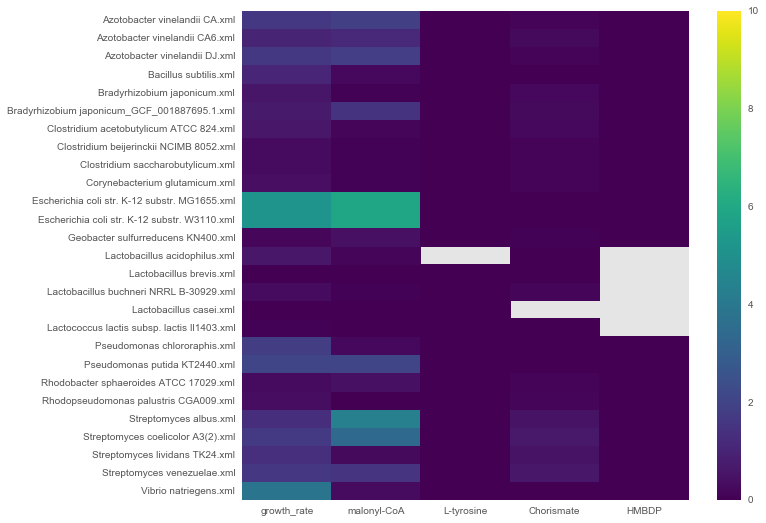

In [25]:
plt.subplots(figsize=(10,9)) #Ploting a heatmap
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
sns.heatmap(data=df.iloc[0:,0:5],cmap='viridis',vmin=0, vmax=10)

### Comparing fluxes in *E. coli* model using different biomass function

In [41]:
model=read_sbml_model('../iJO1366.xml.gz')
model.objective='BIOMASS_Ec_iJO1366_core_53p95M'
model.slim_optimize()
print('Growth rate: ' + str(model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.flux))
print('malonyl-CoA: ' + str(model.reactions.ACCOAC.flux))
print('L-tyrosine: ' + str(model.reactions.TYRTA.flux))
print('HMBDP: ' + str(model.reactions.MECDPDH5.flux))

Growth rate: 0.9823718127269809
malonyl-CoA: 0.07645799818454097
L-tyrosine: -0.13568421240203787
HMBDP: 0.002346886260604752


In [43]:
model.objective='BIOMASS_Ec_iJO1366_WT_53p95M'
model.slim_optimize()
print('Growth rate: ' + str(model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.flux))
print('malonyl-CoA: ' + str(model.reactions.ACCOAC.flux))
print('L-tyrosine: ' + str(model.reactions.TYRTA.flux))
print('HMBDP: ' + str(model.reactions.MECDPDH5.flux))

Growth rate: 0.986514446952975
malonyl-CoA: 0.03220081806299205
L-tyrosine: -0.1324060230122405
HMBDP: 0.006536644725510406


### Customizing the objective function for all models

Retrieving the Biomass function 'BIOMASS_Ec_iJO1366_WT_53p95M' from the model iJO1366.xml.gz as a dictionary.

In [60]:
model=read_sbml_model('../iJO1366.xml.gz') #Importing the model for E. coli

In [61]:
master_objective=model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.reaction #Getting the string of the biomass function
all_reactants=np.array(re.split('-->',master_objective))#Building a dictionary from the reaction string
products=np.array(re.split(' ',all_reactants[1]))
reactants=np.array(re.split(' ',all_reactants[0]))
def reaction_to_dict(reaction):
    products=np.array(re.split(' ',all_reactants[1]))
    reactants=np.array(re.split(' ',all_reactants[0]))
    reaction={}
    i=0
    while i < len(reactants)-1:
        for j in reactants:
            reaction[reactants[i+1]]=float('-'+reactants[i])
        i+=3
    i=1
    while i < len(products)-1:
        for j in products:
            reaction[products[i+1]]=float('-'+products[i])
        i+=3
    return reaction

In [62]:
biomass_dict= reaction_to_dict(model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.reaction)#Getting the dictionary of the biomass function

How many metabolites in the new biomass function are missing in the built models?

In [51]:
%%time
from cobra import Model, Reaction, Metabolite
from cobra.io import write_sbml_model
models_list=[a for a in os.listdir(".") if re.search("xml",a)]
for model_name in models_list:
    with model as model:
        model=read_sbml_model(model_name)
        biomass=Reaction('BIOMASS_Ec_iJO1366_WT_53p95M')
        biomass.name='E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate'
        biomass.lower_bound=0
        biomass.upper_bound=1000
        model.add_reactions([biomass])
        biomass_not=set() #stores all the metabolites of biomass function not in the model
        for metabolite in biomass_dict.keys():
            if metabolite not in model.metabolites:
                biomass_not.add(metabolite)
        print('metabolites not in %s: '%(model_name) +str(len(biomass_not)))

        
#This code prints the metabolites that are not included in the given model

metabolites not in Azotobacter vinelandii CA.xml: 3
metabolites not in Azotobacter vinelandii CA6.xml: 3
metabolites not in Azotobacter vinelandii DJ.xml: 3
metabolites not in Bacillus subtilis.xml: 14
metabolites not in Bradyrhizobium japonicum.xml: 6
metabolites not in Bradyrhizobium japonicum_GCF_001887695.1.xml: 9
metabolites not in Clostridium acetobutylicum ATCC 824.xml: 11
metabolites not in Clostridium beijerinckii NCIMB 8052.xml: 11
metabolites not in Clostridium saccharobutylicum.xml: 7
metabolites not in Corynebacterium glutamicum.xml: 13
metabolites not in Escherichia coli str. K-12 substr. MG1655.xml: 3
metabolites not in Escherichia coli str. K-12 substr. W3110.xml: 3
metabolites not in Geobacter sulfurreducens KN400.xml: 4
metabolites not in Lactobacillus acidophilus.xml: 24
metabolites not in Lactobacillus brevis.xml: 25
metabolites not in Lactobacillus buchneri NRRL B-30929.xml: 21
metabolites not in Lactobacillus casei.xml: 32
metabolites not in Lactococcus lactis sub

How many metabolites in the new biomass function are missing in all the models?

In [53]:
%%time
from cobra import Model, Reaction, Metabolite
from cobra.io import write_sbml_model
models_list=[a for a in os.listdir(".") if re.search("xml",a)]
biomass_not=set()
for model_name in models_list:
    with model as model:
        model=read_sbml_model(model_name)
        biomass=Reaction('BIOMASS_Ec_iJO1366_WT_53p95M')
        biomass.name='E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate'
        biomass.lower_bound=0
        biomass.upper_bound=1000
        model.add_reactions([biomass])
        for metabolite in biomass_dict.keys():
            if metabolite not in model.metabolites:
                biomass_not.add(metabolite)
print('Metabolites not found in any model:'+ str(len(biomass_not)))

#This script prints the metabolites that are not in any model

Metabolites not found in any model:33
CPU times: user 47.2 s, sys: 752 ms, total: 47.9 s
Wall time: 49.1 s


The following loop adds a new biomass function according to its metabolites content and saves that models in a new folder called './alternative_biomass/'

In [70]:
%%time
#This script replaces the biomass function of the models generated by carveme

from cobra import Model, Reaction, Metabolite
from cobra.io import write_sbml_model
models_list=[a for a in os.listdir(".") if re.search("xml",a)]
with model as model:
    for model_name in models_list:
        biomass_not=set()
        biomass_dict2=biomass_dict
        model=read_sbml_model(model_name)
        biomass=Reaction('BIOMASS_Ec_iJO1366_WT_53p95M')
        biomass.name='E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate'
        biomass.lower_bound=0
        biomass.upper_bound=1000
        model.add_reactions([biomass])
        for metabolite in biomass_dict.keys():
            if metabolite not in model.metabolites:
                biomass_not.add(metabolite)
        for metabolite in biomass_not:
            biomass_dict2.pop(metabolite)
    #for model_name in models_list:
        #model=read_sbml_model(model_name)
        biomass.add_metabolites(biomass_dict2)
        #model.add_reactions([biomass])
        model.objective='BIOMASS_Ec_iJO1366_WT_53p95M'
        write_sbml_model(model, './alternative_biomass/%s'%(model_name))

CPU times: user 1min 2s, sys: 3.13 s, total: 1min 5s
Wall time: 1min 6s


Calculating fluxes again with the new customized biomass function...

In [73]:
models_list=[a for a in os.listdir("./alternative_biomass/") if re.search("xml",a)]

In [77]:
%%time
flux_rates={}     #Creates a dataframe storing the fluxes of Growth, ACCOAC, TYRTA, CHORS, HMBDP for all models
for model_name in models_list:
    model=read_sbml_model('./alternative_biomass/%s'%(model_name))
    model.objective='BIOMASS_Ec_iJO1366_WT_53p95M'
    model.slim_optimize()
    if check_HMBDP(model)[0]:
        hmbdp=check_HMBDP(model)[1]
        if check_chor(model)[0]:
            chor=check_chor(model)[1]
            if check_tyr(model)[0]:
                tyr=check_tyr(model)[1]
                flux_rates[model_name]=[model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.flux,
                                        model.reactions.ACCOAC.flux,
                                        tyr,
                                        chor,
                                        hmbdp
                                        ]
            else:
                chor=check_chor(model)[1]
                hmbdp=check_HMBDP(model)[1]
                flux_rates[model_name]=[model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.flux,
                                        model.reactions.ACCOAC.flux,
                                        np.nan,
                                        chor,
                                        hmbdp
                                        ]
        else:
            if check_tyr(model)[0]:
                tyr=check_tyr(model)[1]
                flux_rates[model_name]=[model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.flux,
                                        model.reactions.ACCOAC.flux,
                                        tyr,
                                        np.nan,
                                        hmbdp
                                        ]
            else:
                hmbdp=check_HMBDP(model)[1]
                flux_rates[model_name]=[model.reactions.GBIOMASS_Ec_iJO1366_WT_53p95M.flux,
                                        model.reactions.ACCOAC.flux,
                                        np.nan,
                                        np.nan,
                                        hmbdp
                                        ]
    else:
        if check_chor(model)[0]:
            chor=check_chor(model)[1]
            if check_tyr(model)[0]:
                tyr=check_tyr(model)[1]
                flux_rates[model_name]=[model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.flux,
                                        model.reactions.ACCOAC.flux,
                                        tyr,
                                        chor,
                                        np.nan
                                        ]
            else:
                chor=check_chor(model)[1]
                flux_rates[model_name]=[model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.flux,
                                        model.reactions.ACCOAC.flux,
                                        np.nan,
                                        chor,
                                        np.nan
                                        ]
        else:
            if check_tyr(model)[0]:
                tyr=check_tyr(model)[1]
                flux_rates[model_name]=[model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.flux,
                                        model.reactions.ACCOAC.flux,
                                        tyr,
                                        np.nan,
                                        np.nan
                                        ]
            else:
                flux_rates[model_name]=[model.reactions.BIOMASS_Ec_iJO1366_WT_53p95M.flux,
                                        model.reactions.ACCOAC.flux,
                                        np.nan,
                                        np.nan,
                                        np.nan
                                        ]
df=pd.DataFrame.from_dict(flux_rates, orient="index")
df.rename(columns={0:'growth_rate',1:'malonyl-CoA',2:'L-tyrosine',3:'Chorismate',4:'HMBDP'}, inplace=True)

CPU times: user 50.3 s, sys: 753 ms, total: 51.1 s
Wall time: 52.8 s


Ploting...

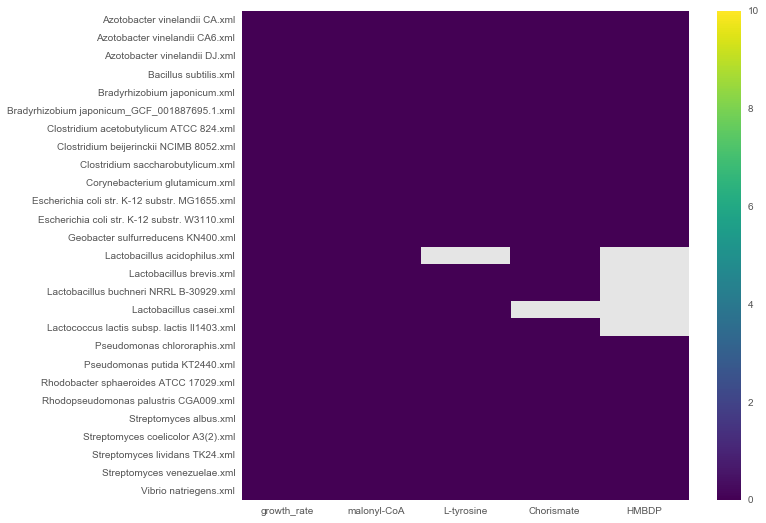

In [78]:
plt.subplots(figsize=(10,9)) #Ploting a heatmap
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
sns.heatmap(data=df.iloc[0:,0:5],cmap='viridis',vmin=0, vmax=10)

- New models are not able to grow :(
- Biomass functions needs to be normalized to 1g of DW
- Gapfilling of new models is necessary...